In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.data import Field, BucketIterator
import numpy as np
import random
from tqdm import tqdm
from torchtext.legacy import data
from termcolor import colored
from torchtext.data.metrics import bleu_score
import pandas as pd
import os
from os import path
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
root="/content/drive/MyDrive/IIMAS/aprendizaje profundo/proyecto"

In [5]:
df=pd.read_csv(path.join(root,"spa.txt"),sep="\t", header=None)
df.drop(2,inplace=True,axis=1)
df.dropna(inplace=True)
df.columns=["English","Spanish"]
df=df[["Spanish","English"]]
df= df.sample(frac=1).reset_index(drop=True)
df

,Spanish,English
0,Me gustó tu idea y la adopté.,I liked your idea and adopted it.
1,Tom está muy disgustado por esto.,Tom is very upset about this.
2,"¿Podría sacarme una foto, por favor?",Would you please take my picture?
3,Él es uno de mis vecinos.,He is one of my neighbours.
4,Parece como si hubiese estado enfermo.,He looks as if he had been ill.
...,...,...
128079,La dama se quedó callada.,The lady remained silent.
128080,Nos gustaría distribuir su producto en Japón.,We would like to distribute your product in Ja...
128081,Puede empezar ahora mismo.,You can start right now.
128082,Él conoce a mucha gente.,He knows a lot of people.


In [6]:
def clean(doc):
    exclude = set(string.punctuation + '¡' + '¿') 
    doc = doc.lower()
    doc = doc.replace("i'm", "i am")
    doc = doc.replace("you're", "you are")
    doc = doc.replace("he's", "he is")
    doc = doc.replace("it's", "it is")
    doc = doc.replace("she's", "she is")
    doc = doc.replace("we're", "we are")
    doc = doc.replace("'ve", " have")
    doc = doc.replace("'d", " would")
    doc = doc.replace("don't", "do not")
    doc = doc.replace("didn't", "did not")
    doc = doc.replace("doesn't", "does not")
    doc = doc.replace("'ll", " will")
    doc = doc.replace("won't", " will not")
    doc = doc.replace("what's", " what is")
    doc = doc.replace("shouldn't", " should not")
    doc = doc.replace("isn't", " is not")
    doc = doc.replace("aren't", " are not")
    doc = doc.replace("wouldn't", "would not")
    doc = doc.replace("couldn't", "could not")
    doc = doc.replace("there's", "there is")
    doc = doc.replace("that's", "that is")
    doc = doc.replace("hasn't", "has not")
    doc = doc.replace("haven't", "have not")
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    return punc_free

In [7]:
df["English"]= df["English"].apply(clean)
df["Spanish"]= df["Spanish"].apply(clean)
df

,Spanish,English
0,me gustó tu idea y la adopté,i liked your idea and adopted it
1,tom está muy disgustado por esto,tom is very upset about this
2,podría sacarme una foto por favor,would you please take my picture
3,él es uno de mis vecinos,he is one of my neighbours
4,parece como si hubiese estado enfermo,he looks as if he had been ill
...,...,...
128079,la dama se quedó callada,the lady remained silent
128080,nos gustaría distribuir su producto en japón,we would like to distribute your product in japan
128081,puede empezar ahora mismo,you can start right now
128082,él conoce a mucha gente,he knows a lot of people


In [8]:
test_size=1000
test_data=df.loc[:test_size-1]
train_data, valid_data = train_test_split(df[test_size-1:], test_size=0.1, shuffle=True, random_state=28)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

test_data.to_csv(path.join(root, "data","es_en_test.csv"),index=False)
train_data.to_csv(path.join(root,"data", "es_en_train.csv"),index=False)
valid_data.to_csv(path.join(root,"data", "es_en_valid.csv"),index=False)

(114376, 2)
(12709, 2)
(1000, 2)


In [5]:
import re
WORD = re.compile(r'\w+')
def tokenizer(text):
    return  WORD.findall(text.lower())

In [6]:
def get_datasets(batch_size=128, embedding=False):
    # Create the pytext's Field

    source = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

    # Splits the data in Train, Test and Validation data
    fields = [('src', source), ('trg', target)]
    train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = path.join(root,"data"),
                                        train = 'es_en_train.csv',
                                        validation = 'es_en_valid.csv',
                                        test = 'es_en_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)
    # Build the vocabulary for both the language

    if not embedding:
      source.build_vocab(train_data)
      target.build_vocab(train_data)     
    else:
      #"glove.42B.300d", 'glove.6B.100d'
      source.build_vocab(train_data,vectors=embedding,unk_init=torch.Tensor.normal_)
      target.build_vocab(train_data,vectors=embedding,unk_init=torch.Tensor.normal_)

    # Create the Iterator using builtin Bucketing
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                          batch_size=batch_size,
                                                                          sort_within_batch=True,
                                                                          sort_key=lambda x: len(x.src),
                                                                          device=device)
    return train_iterator, valid_iterator, test_iterator, source, target

In [7]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.embedding = nn.Embedding(vocab_len, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        outputs, (hidden, cell) = self.rnn(embed)
        return hidden, cell

class OneStepDecoder(nn.Module):
    def __init__(self, input_output_dim, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        # self.input_output_dim will be used later
        self.input_output_dim = input_output_dim
        self.embedding = nn.Embedding(input_output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, input_output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, target_token, hidden, cell):
        target_token = target_token.unsqueeze(0)
        embedding_layer = self.dropout(self.embedding(target_token))
        output, (hidden, cell) = self.rnn(embedding_layer, (hidden, cell))
        linear = self.fc(output.squeeze(0))
        return linear, hidden, cell


class Decoder(nn.Module):
    def __init__(self, one_step_decoder, device):
        super().__init__()
        self.one_step_decoder = one_step_decoder
        self.device = device

    def forward(self, target, hidden, cell, teacher_forcing_ratio=0.5):
        target_len, batch_size = target.shape[0], target.shape[1]
        target_vocab_size = self.one_step_decoder.input_output_dim
        # Store the predictions in an array for loss calculations
        predictions = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        # Take the very first word token, which will be sos
        input = target[0, :]

        # Loop through all the time steps, starts from 1
        for t in range(1, target_len):
            predict, hidden, cell = self.one_step_decoder(input, hidden, cell)

            predictions[t] = predict
            input = predict.argmax(1)

            # Teacher forcing
            do_teacher_forcing = random.random() < teacher_forcing_ratio
            input = target[t] if do_teacher_forcing else input

        return predictions


class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(source)
        outputs = self.decoder(target, hidden, cell, teacher_forcing_ratio)
        return outputs

In [8]:
def create_model(source, target):    
    # Instanciate the models
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters())

    # Makes sure the CrossEntropyLoss ignores the padding tokens.
    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion


def train(train_iterator, valid_iterator, source, target, save, epochs):
    train_loss_values=[]
    val_loss_values=[]
    best_epoch=np.Inf
    model, optimizer, criterion = create_model(source, target)
    clip = 1

    for epoch in range(1, epochs + 1):
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        # set training mode
        model.train()

        # Loop through the training batch
        for i, batch in enumerate(train_iterator):
            # Get the source and target tokens
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            # Forward pass
            output = model(src, trg)

            # reshape the output
            output_dim = output.shape[-1]

            # Discard the first token as this will always be 0
            output = output[1:].view(-1, output_dim)

            # Discard the sos token from target
            trg = trg[1:].view(-1)

            # Calculate the loss
            loss = criterion(output, trg)

            # back propagation
            loss.backward()

            # Gradient Clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

            training_loss.append(loss.item())

            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()

        with torch.no_grad():
            # Set the model to eval
            model.eval()

            validation_loss = []

            # Loop through the validation batch
            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                # Forward pass
                output = model(src, trg, 0)

                output_dim = output.shape[-1]

                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                # Calculate Loss
                loss = criterion(output, trg)

                validation_loss.append(loss.item())

        total_train_loss=round(sum(training_loss) / len(training_loss), 4)
        total_val_loss=round(sum(validation_loss) / len(validation_loss), 4)
        train_loss_values.append(total_train_loss)
        val_loss_values.append(total_val_loss)

        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {total_train_loss}, val loss= {total_val_loss}", refresh=False)
        pbar.close()

        if total_val_loss<best_epoch:
          best_epoch=total_val_loss
          checkpoint = {
              'model_state_dict': model.state_dict(),
              'source': source.vocab,
              'target': target.vocab}
        torch.save(checkpoint, path.join(root,"models",save))
        
    #Graficamos las perdidas
    plt.plot(train_loss_values,label="Train")
    plt.plot(val_loss_values,label="Val")
    plt.legend()
    plt.xticks(list(range(epochs)),list(range(1,epochs+1)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plot=pd.DataFrame({"Train":train_loss_values,"Val":val_loss_values})
    plot.to_csv(path.join(root,"perdidas",f"Losses_{save}"),index=False)
    return model

## Inferencia

In [9]:
def get_test_datasets(batch_size=128):

    # Create the pytext's Field
    source = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

    fields = [('src', source), ('trg', target)]
    test_data = data.TabularDataset(
                                    path = path.join(root,"data","es_en_test.csv"),
                                    fields = fields,
                                    format = 'csv',
                                    skip_header = True)
    return test_data


def create_model_for_inference(source_vocab, target_vocab):

    # Instanciate the models
    encoder = Encoder(len(source_vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)

    one_step_decoder = OneStepDecoder(len(target_vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)
    model = model.to(device)

    return model


def load_models_and_test_data(file_name):
    test_data = get_test_datasets()
    checkpoint = torch.load(path.join(root,"models",file_name))
    source_vocab = checkpoint['source']
    target_vocab = checkpoint['target']
    model = create_model_for_inference(source_vocab, target_vocab)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, source_vocab, target_vocab, test_data


def predict(id, model, source_vocab, target_vocab, test_data, debug=False):
    # src = vars(test_data.examples[id])['src']
    # trg = vars(test_data.examples[id])['trg']
    src = vars(test_data[id])['src']
    trg = vars(test_data[id])['trg']

    # Convert each source token to integer values using the vocabulary
    tokens = ['<sos>'] + [token.lower() for token in src] + ['<eos>']
    src_indexes = [source_vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    model.eval()

    # Run the forward pass of the encoder
    hidden, cell = model.encoder(src_tensor)

    # Take the integer value of <sos> from the target vocabulary.
    trg_index = [target_vocab.stoi['<sos>']]
    next_token = torch.LongTensor(trg_index).to(device)

    outputs = []
    trg_indexes = []

    with torch.no_grad():
        # Use the hidden and cell vector of the Encoder and in loop
        # run the forward pass of the OneStepDecoder until some specified
        # step (say 50) or when <eos> has been generated by the model.
        for _ in range(30):
            output, hidden, cell = model.decoder.one_step_decoder(next_token, hidden, cell)

            # Take the most probable word
            next_token = output.argmax(1)

            trg_indexes.append(next_token.item())

            predicted = target_vocab.itos[output.argmax(1).item()]
            if predicted == '<eos>':
                break
            else:
                outputs.append(predicted)
    if debug:
        print(f"\nSource          ="," ".join(src) )
        print(colored(f'Ground Truth    = {" ".join(trg)}', 'green'))
        print(colored(f'Predicted Label = {" ".join(outputs)}', 'red'))

    predicted_words = [target_vocab.itos[i] for i in trg_indexes]
    return predicted_words


def cal_bleu_score(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['trg']
        predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
        predictions.append(predicted_words[1:-1])
        targets.append([target])
    print(f'\nBLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

def show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20):
  for i in range (n_examples):
    predict(i, model, source_vocab, target_vocab, test_data, debug=True)
  cal_bleu_score(test_data, model, source_vocab, target_vocab)

## Modelo 1

#### Entrenamiento

100%|██████████| 382/382 [02:35<00:00,  2.45 batches/s, epoch=10, train loss= 1.3972, val loss= 2.4483]                                                                                                 


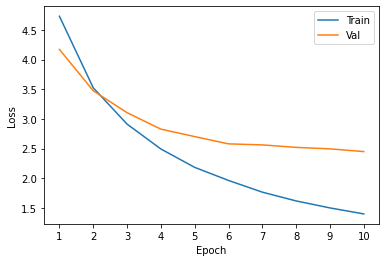

CPU times: user 25min 25s, sys: 26.4 s, total: 25min 51s
Wall time: 26min 15s


In [14]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'es_en_nmt-model-lstm-2L.pth'
embedding=False
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

#### Inferencia

In [16]:
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers=2
save='es_en_nmt-model-lstm-2L.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = me gustó tu idea y la adopté
Ground Truth    = i liked your idea and adopted it
Predicted Label = i like your idea and the

Source          = tom está muy disgustado por esto
Ground Truth    = tom is very upset about this
Predicted Label = tom is very upset about this

Source          = podría sacarme una foto por favor
Ground Truth    = would you please take my picture
Predicted Label = could you send me a picture of me

Source          = él es uno de mis vecinos
Ground Truth    = he is one of my neighbours
Predicted Label = he is one of my neighbors

Source          = parece como si hubiese estado enfermo
Ground Truth    = he looks as if he had been ill
Predicted Label = it looks like if she was sick

Source          = nuestro frigorífico está estropeado
Ground Truth    = our refrigerator is out of order
Predicted Label = our fridge is broken

Source          = quiero que me hagas un favor
Ground Truth    = i want you to do me a favor
Predicted Label = i want you t

## Modelo 2

#### Entrenamiento

100%|██████████| 382/382 [03:10<00:00,  2.00 batches/s, epoch=10, train loss= 1.7536, val loss= 2.6778]                                                                                                 


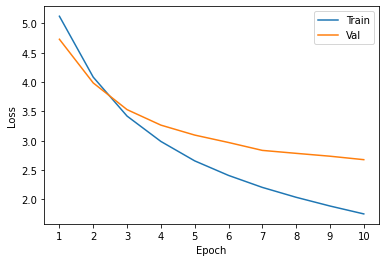

CPU times: user 31min 17s, sys: 28.9 s, total: 31min 46s
Wall time: 32min 5s


In [17]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers = 3
save = 'es_en_nmt-model-lstm-3L.pth'
embedding=False
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

#### Inferencia

In [18]:
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers=3
save='es_en_nmt-model-lstm-3L.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = me gustó tu idea y la adopté
Ground Truth    = i liked your idea and adopted it
Predicted Label = i like your name and the the first way

Source          = tom está muy disgustado por esto
Ground Truth    = tom is very upset about this
Predicted Label = tom is very busy about this

Source          = podría sacarme una foto por favor
Ground Truth    = would you please take my picture
Predicted Label = could you please send a photo

Source          = él es uno de mis vecinos
Ground Truth    = he is one of my neighbours
Predicted Label = he is one of my neighbors

Source          = parece como si hubiese estado enfermo
Ground Truth    = he looks as if he had been ill
Predicted Label = it seems like if he had been ill

Source          = nuestro frigorífico está estropeado
Ground Truth    = our refrigerator is out of order
Predicted Label = our fridge is broken

Source          = quiero que me hagas un favor
Ground Truth    = i want you to do me a favor
Predicted Label = 

## Modelo 3
### Transferencia de conocimiento


#### Entrenamiento

100%|██████████| 382/382 [02:36<00:00,  2.45 batches/s, epoch=10, train loss= 1.3742, val loss= 2.4655]                                                                                                 


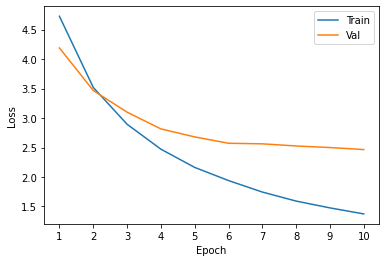

CPU times: user 25min 32s, sys: 34.2 s, total: 26min 6s
Wall time: 26min 25s


In [10]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'es_en_nmt-model-lstm-glove-2L.pth'
embedding="glove.42B.300d"
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

#### Inferencia

In [11]:
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers=2
save='es_en_nmt-model-lstm-glove-2L.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = me gustó tu idea y la adopté
Ground Truth    = i liked your idea and adopted it
Predicted Label = i like your idea and had the idea

Source          = tom está muy disgustado por esto
Ground Truth    = tom is very upset about this
Predicted Label = tom is very upset about this

Source          = podría sacarme una foto por favor
Ground Truth    = would you please take my picture
Predicted Label = could you please me a picture please

Source          = él es uno de mis vecinos
Ground Truth    = he is one of my neighbours
Predicted Label = he is one of my neighbors

Source          = parece como si hubiese estado enfermo
Ground Truth    = he looks as if he had been ill
Predicted Label = he seems like he been ill ill ill

Source          = nuestro frigorífico está estropeado
Ground Truth    = our refrigerator is out of order
Predicted Label = our fridge is broken

Source          = quiero que me hagas un favor
Ground Truth    = i want you to do me a favor
Predicted Labe

## Modelo 4

100%|██████████| 382/382 [02:41<00:00,  2.36 batches/s, epoch=10, train loss= 1.3039, val loss= 2.417]                                                                                                  


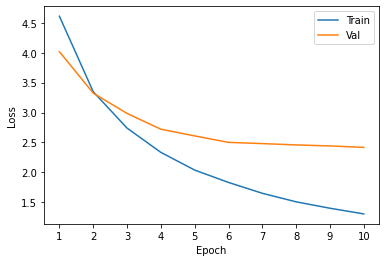

CPU times: user 26min 22s, sys: 31.8 s, total: 26min 54s
Wall time: 27min 15s


In [10]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'es_en_nmt-model-lstm-glove-2L-512.pth'
embedding=False
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

In [11]:
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers=2
save='es_en_nmt-model-lstm-glove-2L-512.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = me gustó tu idea y la adopté
Ground Truth    = i liked your idea and adopted it
Predicted Label = i like your idea and friendship

Source          = tom está muy disgustado por esto
Ground Truth    = tom is very upset about this
Predicted Label = tom is very upset about this

Source          = podría sacarme una foto por favor
Ground Truth    = would you please take my picture
Predicted Label = could you please send me a picture

Source          = él es uno de mis vecinos
Ground Truth    = he is one of my neighbours
Predicted Label = he is one of my neighbors

Source          = parece como si hubiese estado enfermo
Ground Truth    = he looks as if he had been ill
Predicted Label = he seems to if he has been ill

Source          = nuestro frigorífico está estropeado
Ground Truth    = our refrigerator is out of order
Predicted Label = our fridge is broken

Source          = quiero que me hagas un favor
Ground Truth    = i want you to do me a favor
Predicted Label = i w

## Modelo 5

100%|██████████| 382/382 [02:48<00:00,  2.27 batches/s, epoch=10, train loss= 1.3056, val loss= 2.4179]                                                                                                 


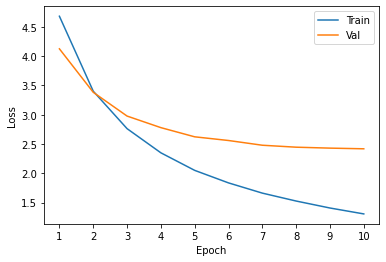

CPU times: user 26min 21s, sys: 1min 42s, total: 28min 4s
Wall time: 28min 27s


In [12]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'es_en_nmt-model-lstm-glove512-2L.pth'
embedding="glove.42B.300d"
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

In [13]:
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers=2
save='es_en_nmt-model-lstm-glove512-2L.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = me gustó tu idea y la adopté
Ground Truth    = i liked your idea and adopted it
Predicted Label = i liked your idea and and the idea

Source          = tom está muy disgustado por esto
Ground Truth    = tom is very upset about this
Predicted Label = tom is very angry about this

Source          = podría sacarme una foto por favor
Ground Truth    = would you please take my picture
Predicted Label = could you send me a photo please

Source          = él es uno de mis vecinos
Ground Truth    = he is one of my neighbours
Predicted Label = he is one of my neighbors

Source          = parece como si hubiese estado enfermo
Ground Truth    = he looks as if he had been ill
Predicted Label = he seems like if he had been ill

Source          = nuestro frigorífico está estropeado
Ground Truth    = our refrigerator is out of order
Predicted Label = our fridge is broken

Source          = quiero que me hagas un favor
Ground Truth    = i want you to do me a favor
Predicted Label = 